In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
import os

In [3]:
datasets_path: str ='../datasets/'

In [12]:
items: pd.DataFrame = pd.read_csv(f'{datasets_path}kion_dataset_items.csv')
users: pd.DataFrame = pd.read_csv(f'{datasets_path}kion_dataset_users.csv')
interactions: pd.DataFrame = pd.read_csv(f'{datasets_path}kion_dataset_interactions.csv')
holidays = pd.read_excel(f'{datasets_path}days_off.xlsx')

In [13]:
holidays['last_watch_dt'] = pd.to_datetime(holidays['last_watch_dt'], format = '%Y-%m-%d')
all_df: pd.DataFrame = interactions.merge(users)
all_df: pd.DataFrame = all_df.merge(items)
all_df.index.rename('watch_id', inplace=True)
all_df: pd.DataFrame = all_df.reset_index()
all_df: pd.DataFrame = all_df.drop(columns = ['studios', 'Unnamed: 0', 'countries', 'directors', 'actors', 'description', 'keywords', 'watch_id', 'title_orig', 'for_kids'])
items['genres_count'] = items['genres'].apply(lambda x: len(x.split(',')))
all_df: pd.DataFrame = all_df[all_df['watched_pct'].isna() == False]

In [14]:
if not os.path.exists('./figures'):
    os.mkdir('figures')

In [15]:
all_df['last_watch_dt'] = pd.to_datetime(all_df['last_watch_dt'], format = '%Y-%m-%d')
all_df['day_week'] = all_df['last_watch_dt'].dt.weekday

In [16]:
all_df: pd.DataFrame = all_df.merge(holidays)
all_df: pd.DataFrame = all_df.drop(columns = ['Unnamed: 0'])
all_df: pd.DataFrame = all_df[all_df['content_type'] == 'film']
all_df['genres_count'] = all_df['genres'].apply(lambda x: len(x.split(',')))

In [10]:
items: pd.DataFrame = items[items['content_type'] == 'film']
all_genres: list[str] = items['genres'].tolist()
set_count_unique_genres: defaultdict[int, int] = defaultdict(int)
for i in range(len(all_genres)):
    film_genres_no_spaces: list[str] = all_genres[i].replace(" ", "").split(',')
    for j in film_genres_no_spaces:
        set_count_unique_genres[j] += 1
set_count_unique_genres.pop('фильмы')
set_count_unique_genres.pop('сериалы')

1

In [18]:
genres_support: dict = defaultdict(int)
genres_multiple_entries: list[int] = items[items['genres_count'] > 1]['genres'].tolist()
two_first_genres_count: dict = defaultdict(int)
genres_to_skip: list[str] = ['фильмы', 'сериалы']

for i in range(len(genres_multiple_entries)):
    film_genres: list[str] = genres_multiple_entries[i].replace(" ", "").split(',')

    first_two_genres: list[str] = film_genres[:2]
    first_two_genres_str: str = ' '.join(first_two_genres)

    first_two_genres_reversed: list[str] = first_two_genres[::-1]
    first_two_genres_reversed_str: str = ' '.join(first_two_genres_reversed)

    if first_two_genres[0] in genres_to_skip or first_two_genres[1] in genres_to_skip:
        continue

    if first_two_genres_str in two_first_genres_count:
        two_first_genres_count[first_two_genres_str] += 1
    else:
        two_first_genres_count[first_two_genres_reversed_str] += 1

    genres_support[first_two_genres[0]] += 1
    genres_support[first_two_genres[1]] += 1


In [10]:
table_lift = pd.DataFrame(columns = ['genre1', 'genre2', 'support1', 'support2', 'more_popular_genre', 'multiple_support', 'support_1_2', 'lift'])
for key_one in genres_support.keys():
    for key_two in genres_support.keys():
        if key_one == key_two:
            continue
        genres: str = f'{key_one} {key_two}'
        genres_reversed: str = f'{key_two} {key_one}'

        support_multiple: int = genres_support[key_one] * genres_support[key_two]

        number_of_entries: int = 0
        found_in_genres_index: int = -1
        
        if genres in two_first_genres_count:
            number_of_entries = two_first_genres_count[genres]
            found_in_genres_index = 1
        elif genres_reversed in two_first_genres_count:
            number_of_entries = two_first_genres_count[genres_reversed]
            found_in_genres_index = 2
        
        if found_in_genres_index == -1:
            continue
        
        # determine which genre is the main one
        correct_genres_order: str = key_one if set_count_unique_genres[key_one] > set_count_unique_genres[key_two] else key_two
        line_to_add: list = []
        if found_in_genres_index == 2:
            line_to_add: list = [key_one, key_two, genres_support[key_one], genres_support[key_two], correct_genres_order, support_multiple, number_of_entries, number_of_entries / support_multiple]
        else:
            line_to_add: list = [key_two, key_one, genres_support[key_two], genres_support[key_one], correct_genres_order, support_multiple, number_of_entries, number_of_entries / support_multiple]
        table_lift.loc[len(table_lift.index)] = line_to_add
table_lift = table_lift.drop_duplicates()
table_lift = table_lift.sort_values('lift', ascending = False)

In [11]:
table_lift[(table_lift['genre1'] == 'хочувсёзнать') | (table_lift['genre2'] == 'хочувсёзнать')]

,genre1,genre2,support1,support2,more_popular_genre,multiple_support,support_1_2,lift
56,хочувсёзнать,биография,3,312,биография,936,2,0.002137
476,длядетей,хочувсёзнать,260,3,длядетей,780,1,0.001282


In [12]:
all_df[all_df['day_off'] == 1]['total_dur'].sum() / all_df['total_dur'].sum()

0.3302353473367644

In [13]:
all_df[all_df['holiday'] == 1]['total_dur'].sum() / all_df['total_dur'].sum()

0.04031027557927903

In [14]:
(all_df[all_df['day_off'] == 1]['total_dur'].sum() + all_df[all_df['holiday'] == 1]['total_dur'].sum()) / all_df['total_dur'].sum()

0.3705456229160434

In [15]:
all_df[all_df['day_off'] == 1]

,user_id,item_id,last_watch_dt,total_dur,watched_pct,age,income,sex,kids_flg,content_type,title,release_year,genres,age_rating,valid_from_dttm,rating_kp,day_week,day_off,holiday,genres_count
17754,699317,9506,2021-05-01,5396,92.0,age_35_44,income_40_60,М,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,5,1,0,3
17755,1045343,9506,2021-05-01,6108,100.0,age_35_44,income_20_40,М,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,5,1,0,3
17756,18806,9506,2021-05-01,5401,92.0,age_25_34,income_40_60,Ж,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,5,1,0,3
17757,341136,9506,2021-05-01,5346,91.0,age_25_34,income_40_60,Ж,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,5,1,0,3
17758,483733,9506,2021-05-01,7422,100.0,age_25_34,income_20_40,Ж,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,5,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378960,969611,10390,2021-03-20,89,2.0,age_18_24,income_60_90,М,0,film,Родители лёгкого поведения (жестовым языком),2019.0,"зарубежные, комедии",18.0,2021-03-17 20:35:50,4.81,5,1,0,2
4378961,969611,6199,2021-03-20,64,1.0,age_18_24,income_60_90,М,0,film,Родители лёгкого поведения (с тифлокомментарием),2019.0,"зарубежные, комедии",18.0,2021-03-17 20:35:59,4.80,5,1,0,2
4378962,826970,9233,2021-03-20,4521,88.0,age_35_44,income_20_40,М,1,film,Ибица (с тифлокомментарием),2019.0,"зарубежные, комедии",16.0,2021-03-18 09:55:59,5.58,5,1,0,2
4378963,79675,5548,2021-03-20,591,12.0,age_65_inf,income_20_40,М,0,film,Путешествие в Италию,1954.0,"драмы, зарубежные, мелодрамы",16.0,2019-10-13 15:41:46,7.10,5,1,0,3


In [16]:
all_df[all_df['holiday'] == 1].drop_duplicates(subset='last_watch_dt')

,user_id,item_id,last_watch_dt,total_dur,watched_pct,age,income,sex,kids_flg,content_type,title,release_year,genres,age_rating,valid_from_dttm,rating_kp,day_week,day_off,holiday,genres_count
56293,896751,9506,2021-05-03,5431,92.0,age_35_44,income_40_60,М,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,0,0,1,3
1244832,1097078,9506,2021-05-04,942,16.0,age_45_54,income_20_40,Ж,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,1,0,1,3
1303418,549089,9506,2021-05-06,5951,100.0,age_18_24,income_40_60,М,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,3,0,1,3
1556417,967506,9506,2021-05-07,7,0.0,NaN,NaN,NaN,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,4,0,1,3
2276861,910001,9506,2021-05-05,19,0.0,age_35_44,income_40_60,М,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,2,0,1,3
3921584,1051100,9506,2021-05-10,6969,100.0,age_18_24,income_40_60,Ж,0,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,0,0,1,3
4021254,1069949,9506,2021-06-14,617,10.0,age_25_34,income_20_40,М,1,film,Холодное сердце,2013.0,"фэнтези, мультфильм, музыкальные",0.0,2019-11-01 13:00:00,NaN,0,0,1,3


In [17]:
all_df[all_df['last_watch_dt'] == '2021-05-03']['total_dur'].describe()

count     18104.000000
mean       4665.536401
std        8614.260089
min           1.000000
25%         370.000000
50%        3040.000000
75%        6739.000000
max      360289.000000
Name: total_dur, dtype: float64

In [18]:
all_df[all_df['day_week'] == 0]['total_dur'].describe()

count    458876.000000
mean       4537.250105
std        9496.318743
min           1.000000
25%         385.000000
50%        2641.000000
75%        6468.000000
max      910785.000000
Name: total_dur, dtype: float64

Text(0.5, 1.0, 'Распределение watched_pct на первый майский праздник (понедельник)')

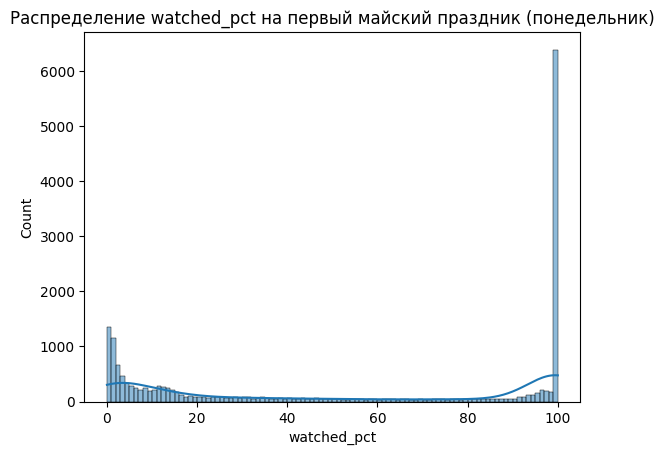

In [19]:
sns.histplot(all_df[all_df['last_watch_dt'] == '2021-05-03'], x="watched_pct", bins=100, kde=True)
plt.title("Распределение watched_pct на первый майский праздник (понедельник)")

Text(0.5, 1.0, 'Распределение watched_pct на Праздниках')

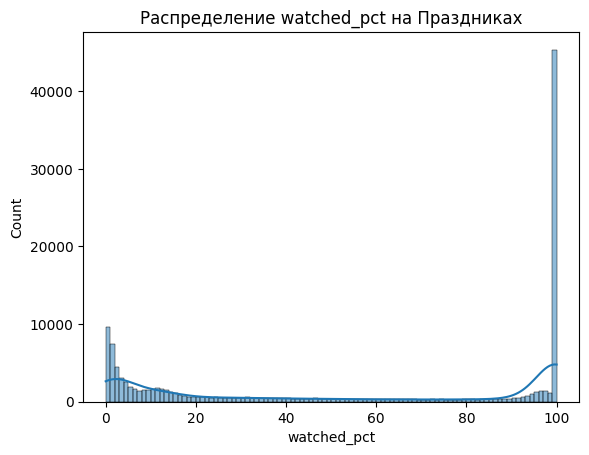

In [20]:
all_df_holiday = all_df[all_df['holiday'] == 1]
sns.histplot(all_df_holiday, x="watched_pct", bins=100, kde=True)
plt.title("Распределение watched_pct на Праздниках")

Text(0.5, 1.0, 'Распределение watched_pct на Выходных')

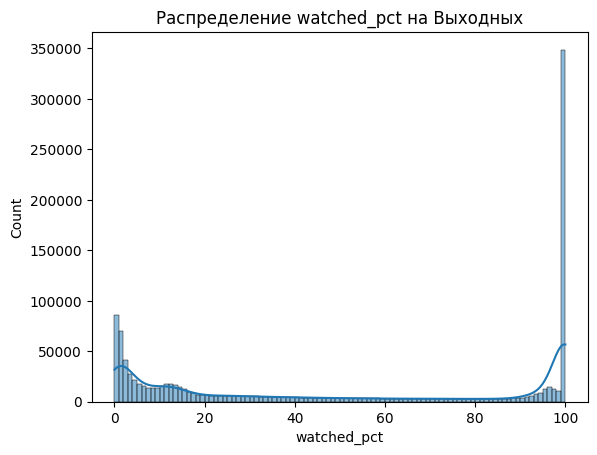

In [21]:
all_df_day_off = all_df[all_df['day_off'] == 1]
sns.histplot(all_df_day_off, x = "watched_pct", bins=100, kde=True)
plt.title("Распределение watched_pct на Выходных")

Text(0.5, 1.0, 'Распределение watched_pct по будням')

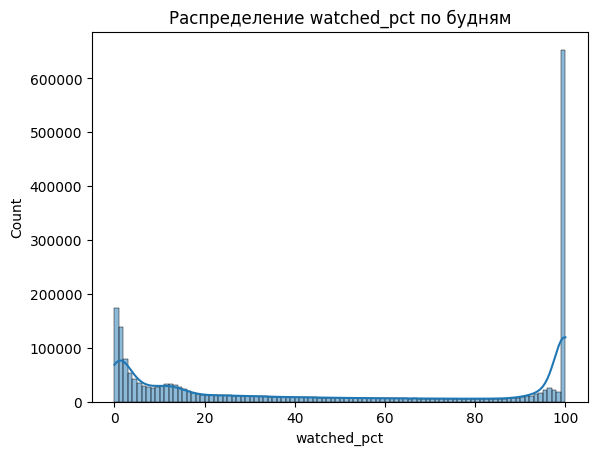

In [22]:
all_df_budni = all_df[(all_df['holiday'] == 0) & (all_df['day_off'] == 0)]
sns.histplot(all_df_budni, x = "watched_pct", bins=100, kde=True)
plt.title("Распределение watched_pct по будням")

In [23]:
stats.levene(all_df_budni['watched_pct'], all_df_day_off['watched_pct'], center='trimmed')

LeveneResult(statistic=270.392161599384, pvalue=9.378316331805237e-61)

In [24]:
stats.levene(all_df_budni['watched_pct'], all_df_holiday['watched_pct'], center='trimmed')

LeveneResult(statistic=1170.9254952543463, pvalue=1.499529810359732e-256)

In [25]:
stats.levene(all_df_day_off['watched_pct'], all_df_holiday['watched_pct'], center='trimmed')

LeveneResult(statistic=767.1272833886167, pvalue=8.631522822789115e-169)

In [26]:
stats.levene(all_df_day_off['watched_pct'], all_df_holiday['watched_pct'], all_df_budni['watched_pct'], center='trimmed')

LeveneResult(statistic=663.7929228621542, pvalue=6.029847005966967e-289)

In [27]:
all_df.drop_duplicates(subset = 'item_id').shape

(11280, 20)

Text(0.5, 1.0, 'Корреляция численных признаков (фильмы)')

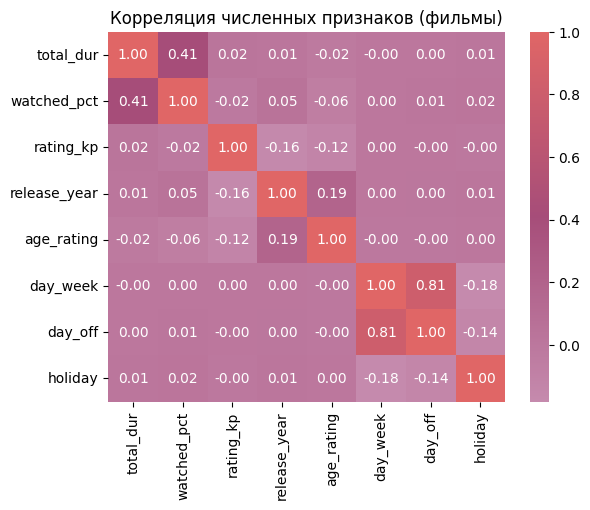

In [28]:
all_df_coll: pd.DataFrame = pd.DataFrame(all_df, columns = ['total_dur', 'watched_pct', 'rating_kp', 'release_year', 'age_rating', 'day_week', 'day_off', 'holiday'])
sns.heatmap(all_df_coll.corr(), annot = True, cmap = LinearSegmentedColormap.from_list('custom', ['#C58AAD', '#A64D79', '#E06666']), fmt = ".2f")
plt.title("Корреляция численных признаков (фильмы)")

In [30]:
def filter_by_date(data: pd.DataFrame, index: int) -> pd.DataFrame:
    return data[data['day_week'] == index]

index_to_day: dict[int, str] = {0: 'Понедельник', 1: 'Втоник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
all_df_by_day: dict[int, pd.DataFrame] = {i: filter_by_date(all_df, i) for i in range(7)}

for key, value in all_df_by_day.items():
    print(f'{key} - {value.shape}, length (days): {value.total_dur.sum() / 86400}')

0 - (458876, 20), length (days): 24097.629386574074
1 - (454042, 20), length (days): 22940.408333333333
2 - (451963, 20), length (days): 22721.030694444446
3 - (458317, 20), length (days): 22983.801377314816
4 - (480613, 20), length (days): 24163.246064814815
5 - (550004, 20), length (days): 27660.39238425926
6 - (579575, 20), length (days): 29981.54440972222


In [31]:
if not os.path.exists('./figures/watched_pct'):
    os.mkdir('./figures/watched_pct')

for day_index in all_df_by_day:
    sns.histplot(all_df_by_day[day_index], x="watched_pct", kde=True, bins=100)
    plt.title(f"Распределение watched_pct в {index_to_day[day_index]}")
    plt.savefig(f'./figures/watched_pct/watched_pct_{index_to_day[day_index]}.jpg')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [32]:
for day_index, day_data in all_df_by_day.items():
    print(f'Std ({index_to_day[day_index]}) - {day_data.watched_pct.std()}')

Std (Понедельник) - 42.35176817329457
Std (Втоник) - 42.21404245152328
Std (Среда) - 42.22646265414596
Std (Четверг) - 42.20239285066259
Std (Пятница) - 42.24287775159513
Std (Суббота) - 42.328787821785774
Std (Воскресенье) - 42.32462536526485
